In [3]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#import functions
from functions import *

In [5]:
#download provided NFL data
df_games = pd.read_csv('games.csv')
df_player_play = pd.read_csv('player_play.csv')
df_players = pd.read_csv('players.csv')
df_plays = pd.read_csv('plays.csv')
df_w1 = pd.read_csv('tracking_week_1.csv')
df_w2 = pd.read_csv('tracking_week_2.csv')
df_w3 = pd.read_csv('tracking_week_3.csv')
df_w4 = pd.read_csv('tracking_week_4.csv')
df_w5 = pd.read_csv('tracking_week_5.csv')
df_w6 = pd.read_csv('tracking_week_6.csv')
df_w7 = pd.read_csv('tracking_week_7.csv')
df_w8 = pd.read_csv('tracking_week_8.csv')
df_w9 = pd.read_csv('tracking_week_9.csv')

In [6]:
#concatenate the player tracking dataframes
tracking = pd.concat([df_w1,df_w2,df_w3,df_w4,df_w5,df_w6,df_w7,df_w8,df_w9])

In [7]:
#standardize the tracking dataframe
standardize_df(tracking)

In [8]:
#drop unnecessary columns
tracking = tracking.drop(columns=['x', 'y', 's', 'a','dis', 'o', 'dir','time','jerseyNumber','playDirection'])

In [9]:
#get the nflIds of all players on a play who motioned
df_player_play_motion_ids = df_player_play[df_player_play['motionSinceLineset'] == True][['gameId', 'playId', 'nflId']]

#filter tracking to only data from players who motioned
tracking_motion = tracking.merge(df_player_play_motion_ids, on = ['gameId','playId','nflId'], how = 'inner')

In [10]:
#remove specific play with incorrectly labeled events
tracking_motion = tracking_motion[(tracking_motion['gameId'] != 2022102700) | (tracking_motion['playId'] != 1325)]

In [11]:
#get ids for kneels, spikes, and plays nullified by penalty
df_plays_simple = df_plays[(df_plays['playNullifiedByPenalty'] == 'N') & (df_plays['qbSpike'] != True) & (df_plays['qbKneel'] != 1)][['gameId', 'playId']]

#remove plays that fell into those categories
tracking_motion = tracking_motion.merge(df_plays_simple, on=['gameId', 'playId'], how='inner')

In [12]:
#find the football location on every play
tracking_football = tracking[tracking['displayName'] == 'football'][['gameId','playId','frameId','x_std','y_std']]

#add columns to tracking with the football's x and y coordinates
tracking_motion = tracking_motion.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

#calculate the distance from the player to the football
tracking_motion['dis_fb_x'] = tracking_motion['x_std'] - tracking_motion['x_std_fb']
tracking_motion['dis_fb_y'] = tracking_motion['y_std'] - tracking_motion['y_std_fb']

In [13]:
#filter tracking data to appear only between the line set and the ball snap
tracking_motion_filtered = filter_to_between_line_set_ball_snap(tracking_motion)

In [14]:
#drop frameType column, not needed any more
tracking_simple = tracking_motion_filtered.drop(columns=['frameType'])

In [15]:
#calculate frames before snap (note: a frame is .1 second)
tracking_simple['frames_bf_snap'] = tracking_simple['frameId_bs'] - tracking_simple['frameId']

In [16]:
#make columns of the player's coordinates at the linesnap
tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_x_std'] = tracking_simple['x_std']
tracking_simple['initial_x_std'] = tracking_simple['initial_x_std'].ffill().astype(int)

tracking_simple.loc[tracking_simple['frameId'] == tracking_simple['frameId_ls'], 'initial_y_std'] = tracking_simple['y_std']
tracking_simple['initial_y_std'] = tracking_simple['initial_y_std'].ffill().astype(int)

#find how far the player has moved from their initial coordinates at every frame
tracking_simple['x_change_all'] = tracking_simple['initial_x_std'] - tracking_simple['x_std']
tracking_simple['y_change_all'] = tracking_simple['initial_y_std'] - tracking_simple['y_std']

In [17]:
#find change in x,y coordinates per frame
tracking_simple['x_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_simple['y_change'] = tracking_simple.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

In [18]:
#create an estimate of how fast a person is in motion, see what the change in y is

#first observe players not in motion/shifting
df_player_play_motion_ids_false = df_player_play[(df_player_play['motionSinceLineset'] == False)&(df_player_play['shiftSinceLineset'] == False)][['gameId','playId','nflId']]
tracking_avg_movement = tracking.merge(df_player_play_motion_ids_false, on = ['gameId','playId','nflId'], how = 'inner')

tracking_avg_movement = filter_to_between_line_set_ball_snap(tracking_avg_movement)
tracking_avg_movement = tracking_avg_movement.drop(columns=['frameType','event'])

tracking_avg_movement['x_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['x_std'].diff().fillna(0).astype(int)
tracking_avg_movement['y_change'] = tracking_avg_movement.groupby(['gameId','playId','nflId'])['y_std'].diff().fillna(0).astype(int)

<Axes: xlabel='dis_std', ylabel='Count'>

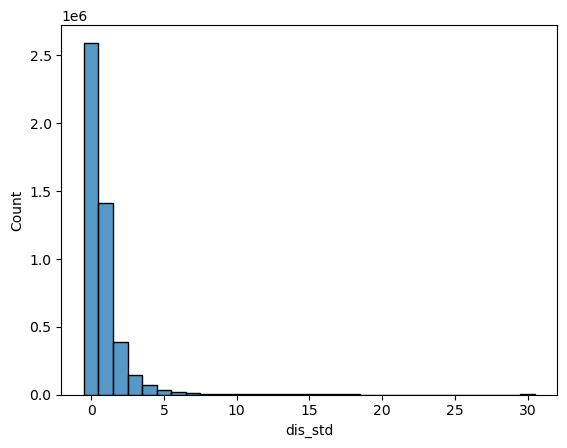

In [19]:
#check average dis_std of someone not in motion/shifting
sns.histplot(tracking_avg_movement['dis_std'].apply(lambda x: min(abs(x), 30)), discrete=True)

In [20]:
tracking_avg_movement['y_change'].describe()

count    4.702742e+06
mean    -2.406681e-03
std      1.619059e+00
min     -1.070000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.460000e+02
Name: y_change, dtype: float64

In [21]:
tracking_avg_movement['y_change'].quantile(.99)

3.0

<Axes: xlabel='dis_std', ylabel='Count'>

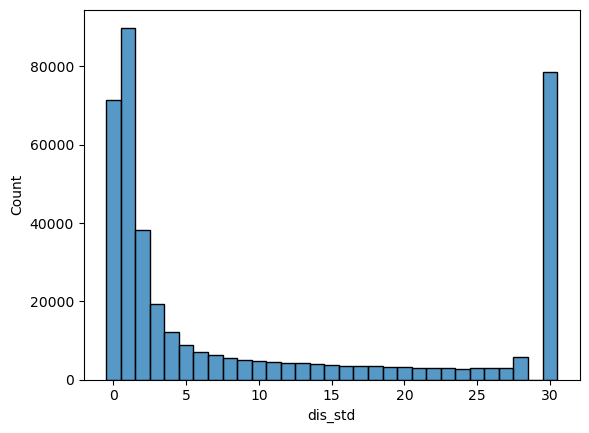

In [22]:
#compare to histograph from players in motion
sns.histplot(tracking_simple['dis_std'].apply(lambda x: min(abs(x), 30)), discrete=True)

In [23]:
#based on above results, mark a player as in motion/shift when their x_change or y_change is 4 or above
tracking_simple['in_motion'] = (tracking_simple['dis_std'].abs() >= 4)*1

In [24]:
#get tracking data for only tackle (needed in feature creation)
tracking_tackles = tracking[tracking['event'] == 'ball_snap']
df_players_line = df_players[df_players['position'] == 'T'][['nflId']]
tracking_tackles = tracking_tackles.merge(df_players_line, on = ['nflId'])[['gameId','playId','y_std']]

In [25]:
# #export csvs for feature creation
tracking_simple.to_csv('tracking_simple.csv',index=False)
tracking_football.to_csv('tracking_football.csv',index=False)
tracking_tackles.to_csv('tracking_tackles.csv',index=False)

In [26]:
#export csv for motion play visualization
tracking_motion_play_vis = tracking_simple[['gameId','playId','nflId','frameId','in_motion']]
tracking_motion_play_vis.to_csv('tracking_motion_play_vis.csv',index=False)

In [27]:
#export csv for vertical, offense-only play visualization
tracking_for_vertical = tracking.copy()
tracking_for_vertical = tracking_for_vertical.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

df_player_play_motion_ids['motion_true'] = 1
tracking_for_vertical = tracking_for_vertical.merge(df_player_play_motion_ids,on=['gameId','playId','nflId'],how='left')
tracking_for_vertical['motion_true'] = tracking_for_vertical['motion_true'].fillna(0)

#remove defensive players
df_plays_off = df_plays[['gameId','playId','possessionTeam']]
tracking_for_vertical = tracking_for_vertical.merge(df_plays_off,on=['gameId','playId'],how='inner')
tracking_for_vertical = tracking_for_vertical[tracking_for_vertical['club'] == tracking_for_vertical['possessionTeam']]

#flag for when a player is in motion
tracking_for_vertical['in_motion'] = (tracking_for_vertical['dis_std'].abs() >= 4)*1 * tracking_for_vertical['motion_true']
tracking_for_vertical = filter_to_between_line_set_ball_snap(tracking_for_vertical)

tracking_for_vertical['dis_fb_x'] = tracking_for_vertical['x_std'] - tracking_for_vertical['x_std_fb']
tracking_for_vertical['dis_fb_y'] = tracking_for_vertical['y_std'] - tracking_for_vertical['y_std_fb']

#remove unneeded columns
tracking_for_vertical = tracking_for_vertical[['gameId', 'playId', 'nflId', 'displayName','frameId','s_std','dis_fb_x','dis_fb_y','motion_true','in_motion']]

#export csv
tracking_for_vertical.to_csv('tracking_vertical.csv')